In [36]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data")
csv_files = sorted(DATA_DIR.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {DATA_DIR.resolve()}")

df = pd.concat((pd.read_csv(path) for path in csv_files), ignore_index=True)
df.head()

,timestamp,impl,op,load_factor,metric,value,unit,tag
0,2026-02-27T04:10:04.043844+00:00,m0_hashbrown,insert_marginal,0.01,mean,7.980766e+04,ns,Hashtable baseline
1,2026-02-27T04:10:04.043844+00:00,m0_hashbrown,insert_marginal,0.01,median,7.980766e+04,ns,Hashtable baseline
2,2026-02-27T04:10:04.043844+00:00,m0_hashbrown,insert_marginal,0.01,std_dev,2.371633e+03,ns,Hashtable baseline
3,2026-02-27T04:10:04.043844+00:00,m0_hashbrown,insert_marginal,0.01,throughput_ops_per_sec,1.603856e+06,ops/s,Hashtable baseline
4,2026-02-27T04:10:04.043844+00:00,m0_hashbrown,insert_marginal,0.25,mean,6.712805e+04,ns,Hashtable baseline


In [38]:
# Benchmark data shape (comparison-ready)
# Keep this summary stable as new implementations arrive so we can compare apples-to-apples.

comparison_dims = ["impl", "op", "load_factor", "metric", "unit", "tag"]
missing_dims = [c for c in comparison_dims if c not in df.columns]
if missing_dims:
    raise ValueError(f"Missing comparison columns: {missing_dims}")

# Normalize type to avoid accidental mismatches across future CSVs (e.g., 0.5 vs "0.50")
df_cmp = df.copy()
df_cmp["load_factor"] = pd.to_numeric(df_cmp["load_factor"], errors="coerce").round(4)

print("Rows x columns:", df_cmp.shape)
print("\nColumns:", list(df_cmp.columns))

print("\nUnique counts per comparison dimension:")
display(df_cmp[comparison_dims].nunique().rename("unique_values").to_frame())

print("\nCoverage by implementation and operation:")
coverage = (
    df_cmp.groupby(["impl", "op"], dropna=False)
    .size()
    .rename("rows")
    .reset_index()
    .sort_values(["impl", "op"])
)
display(coverage)

print("\nApples-to-apples panel shape (impl x shared benchmark points):")
benchmark_key = ["op", "load_factor", "metric", "unit", "tag"]
panel = (
    df_cmp.groupby(["impl", *benchmark_key], dropna=False)
    .agg(value_mean=("value", "mean"), n=("value", "size"))
    .reset_index()
)
display(panel.head(20))
print("Panel rows:", len(panel))

Rows x columns: (700, 8)

Columns: ['timestamp', 'impl', 'op', 'load_factor', 'metric', 'value', 'unit', 'tag']

Unique counts per comparison dimension:


,unique_values
impl,2
op,5
load_factor,5
metric,4
unit,2
tag,16



Coverage by implementation and operation:


,impl,op,rows
0,m0_hashbrown,insert_marginal,32
1,m0_hashbrown,iter,32
2,m0_hashbrown,lookup_hit,32
3,m0_hashbrown,lookup_hit_tiny,8
4,m0_hashbrown,lookup_miss,32
5,radix_tree,insert_marginal,152
6,radix_tree,iter,112
7,radix_tree,lookup_hit,152
8,radix_tree,lookup_hit_tiny,4
9,radix_tree,lookup_miss,144



Apples-to-apples panel shape (impl x shared benchmark points):


,impl,op,load_factor,metric,unit,tag,value_mean,n
0,m0_hashbrown,insert_marginal,0.01,mean,ns,Baseline,7.980766e+04,1
1,m0_hashbrown,insert_marginal,0.01,mean,ns,Hashtable baseline,7.980766e+04,1
2,m0_hashbrown,insert_marginal,0.01,median,ns,Baseline,7.980766e+04,1
3,m0_hashbrown,insert_marginal,0.01,median,ns,Hashtable baseline,7.980766e+04,1
4,m0_hashbrown,insert_marginal,0.01,std_dev,ns,Baseline,2.371633e+03,1
5,m0_hashbrown,insert_marginal,0.01,std_dev,ns,Hashtable baseline,2.371633e+03,1
6,m0_hashbrown,insert_marginal,0.01,throughput_ops_per_sec,ops/s,Baseline,1.603856e+06,1
7,m0_hashbrown,insert_marginal,0.01,throughput_ops_per_sec,ops/s,Hashtable baseline,1.603856e+06,1
8,m0_hashbrown,insert_marginal,0.25,mean,ns,Baseline,6.712805e+04,1
9,m0_hashbrown,insert_marginal,0.25,mean,ns,Hashtable baseline,6.712805e+04,1


Panel rows: 636


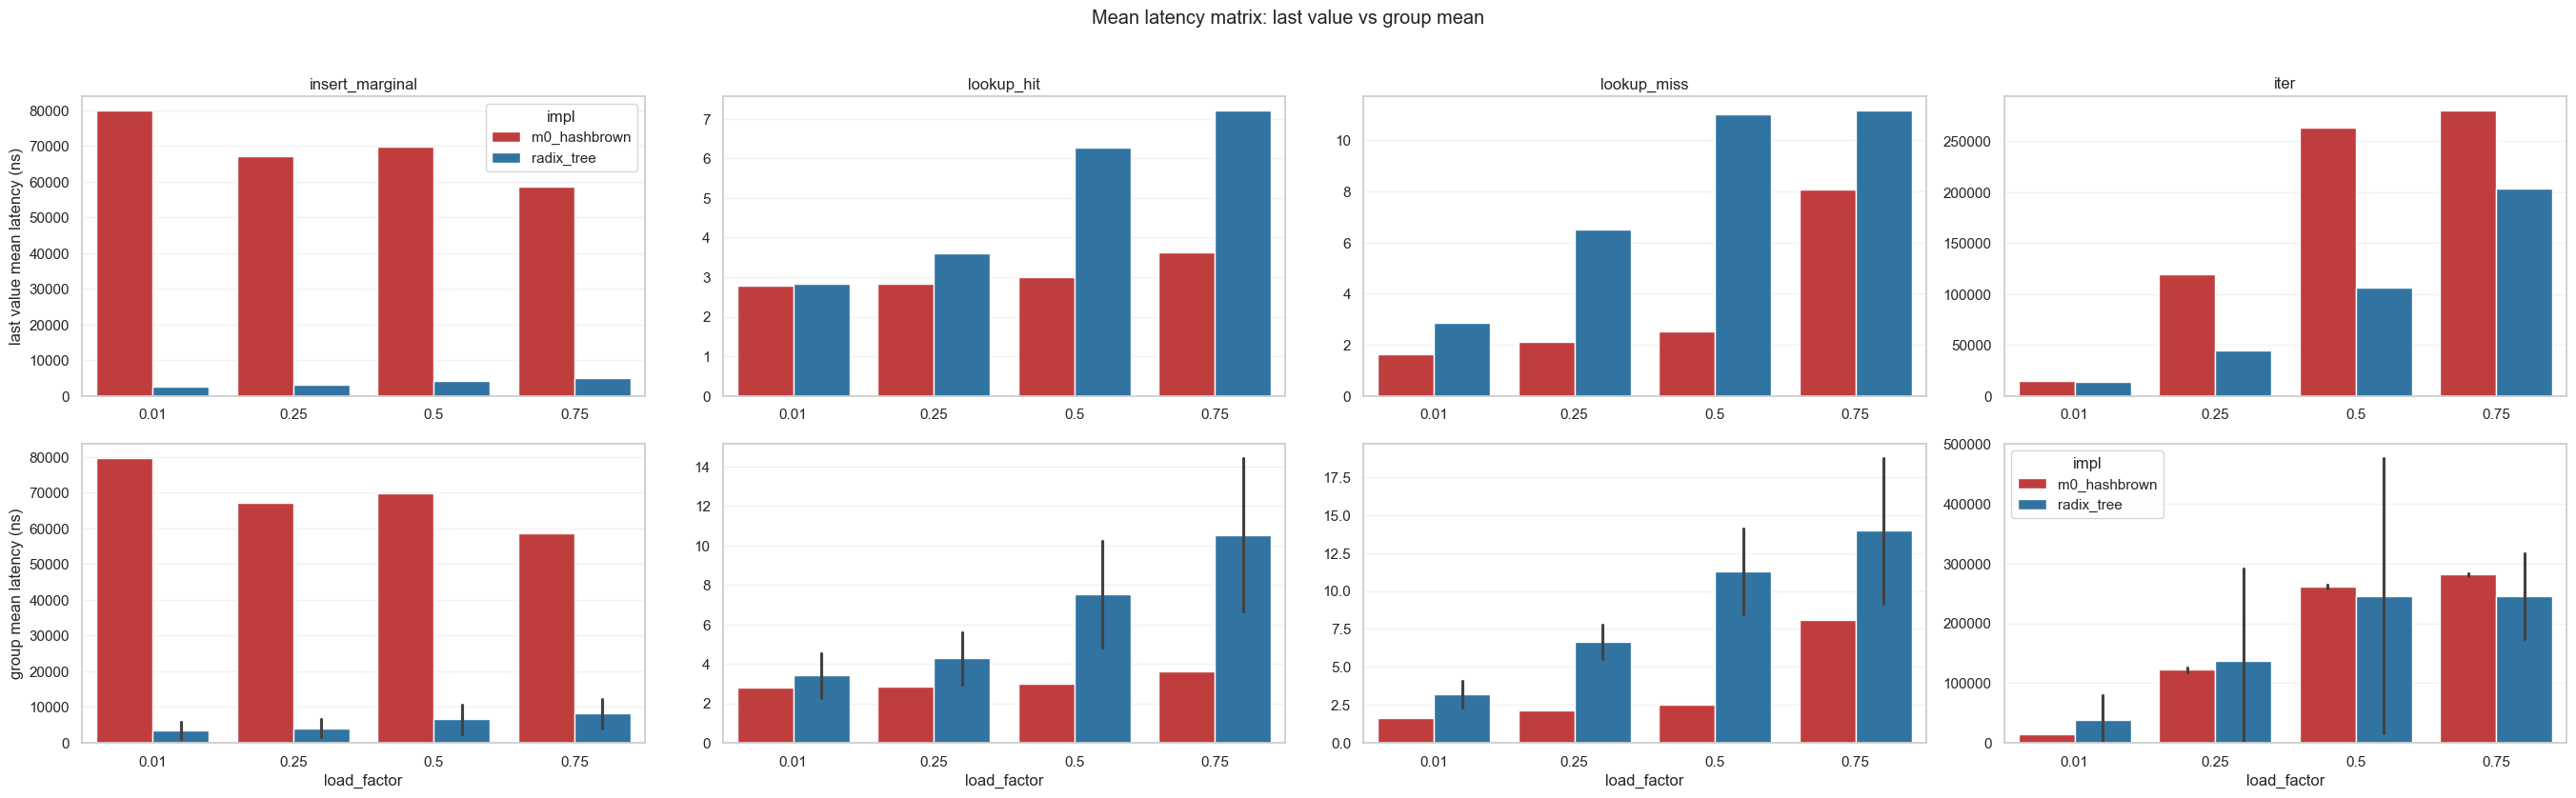

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")

required_cols = ["timestamp", "impl", "op", "load_factor", "metric", "unit", "tag", "value"]
missing_cols = [c for c in required_cols if c not in df_cmp.columns]
if missing_cols:
    raise ValueError(f"Missing columns needed for plotting: {missing_cols}")

plot_df = df_cmp.copy()
plot_df["timestamp"] = pd.to_datetime(plot_df["timestamp"], utc=True, errors="coerce")
plot_df["load_factor"] = pd.to_numeric(plot_df["load_factor"], errors="coerce")

# Two-row matrix for mean latency only:
# - Row 1: last value per impl/op/load_factor
# - Row 2: mean across the group per impl/op/load_factor
mean_df = plot_df[(plot_df["metric"] == "mean") & (plot_df["unit"] == "ns")].copy()

# Keep only core operations for apples-to-apples matrix (exclude lookup_hit_tiny, etc.).
preferred_ops = ["insert_marginal", "lookup_hit", "lookup_miss", "iter"]
ops_present = [op for op in preferred_ops if op in mean_df["op"].unique()]

if not ops_present:
    raise ValueError("No target operations found for matrix chart.")

mean_df = mean_df[mean_df["op"].isin(ops_present)].copy()

# Use load factors common to all shown operations so no panel appears missing due to axis mismatch.
load_sets = [set(mean_df[mean_df["op"] == op]["load_factor"].dropna().unique()) for op in ops_present]
common_loads = sorted(set.intersection(*load_sets)) if load_sets else []
mean_df = mean_df[mean_df["load_factor"].isin(common_loads)].copy()

# Row 1 dataset: last value only (no error bars)
last_mean = (
    mean_df.sort_values(["timestamp", "impl", "op", "load_factor"])
    .drop_duplicates(["impl", "op", "load_factor"], keep="last")
)

fig, axes = plt.subplots(2, len(ops_present), figsize=(6.8 * len(ops_present), 8.2), sharex=False, squeeze=False)

# Keep implementation colors/order fixed across all panels.
impl_order = ["m0_hashbrown", "radix_tree"]
palette = {"m0_hashbrown": "#d62728", "radix_tree": "#1f77b4"}

for c, op in enumerate(ops_present):
    # Top row: last value only
    ax_top = axes[0][c]
    top = last_mean[last_mean["op"] == op].copy()
    top["load_factor"] = pd.Categorical(top["load_factor"], categories=common_loads, ordered=True)

    sns.barplot(
        data=top,
        x="load_factor",
        y="value",
        hue="impl",
        hue_order=impl_order,
        palette=palette,
        estimator="mean",
        errorbar=None,
        ax=ax_top,
    )

    ax_top.set_title(op)
    ax_top.set_xlabel("")
    ax_top.set_ylabel("last value mean latency (ns)" if c == 0 else "")
    y0, y1 = ax_top.get_ylim()
    ax_top.set_ylim(0, y1)
    ax_top.grid(True, axis="y", alpha=0.25)
    if c > 0:
        ax_top.get_legend().remove()

    # Bottom row: mean across group with error bars
    ax_bot = axes[1][c]
    bot = mean_df[mean_df["op"] == op].copy()
    bot["load_factor"] = pd.Categorical(bot["load_factor"], categories=common_loads, ordered=True)

    sns.barplot(
        data=bot,
        x="load_factor",
        y="value",
        hue="impl",
        hue_order=impl_order,
        palette=palette,
        estimator="mean",
        errorbar="sd",
        ax=ax_bot,
    )

    ax_bot.set_xlabel("load_factor")
    ax_bot.set_ylabel("group mean latency (ns)" if c == 0 else "")
    y0, y1 = ax_bot.get_ylim()
    ax_bot.set_ylim(0, y1)
    ax_bot.grid(True, axis="y", alpha=0.25)

    if c == len(ops_present) - 1:
        ax_bot.legend(title="impl", loc="upper left", frameon=True)
    else:
        ax_bot.get_legend().remove()

fig.suptitle("Mean latency matrix: last value vs group mean", y=1.02)
plt.tight_layout()
plt.show()

Using load factors for matrix layout: [0.01, 0.25, 0.5, 0.75]


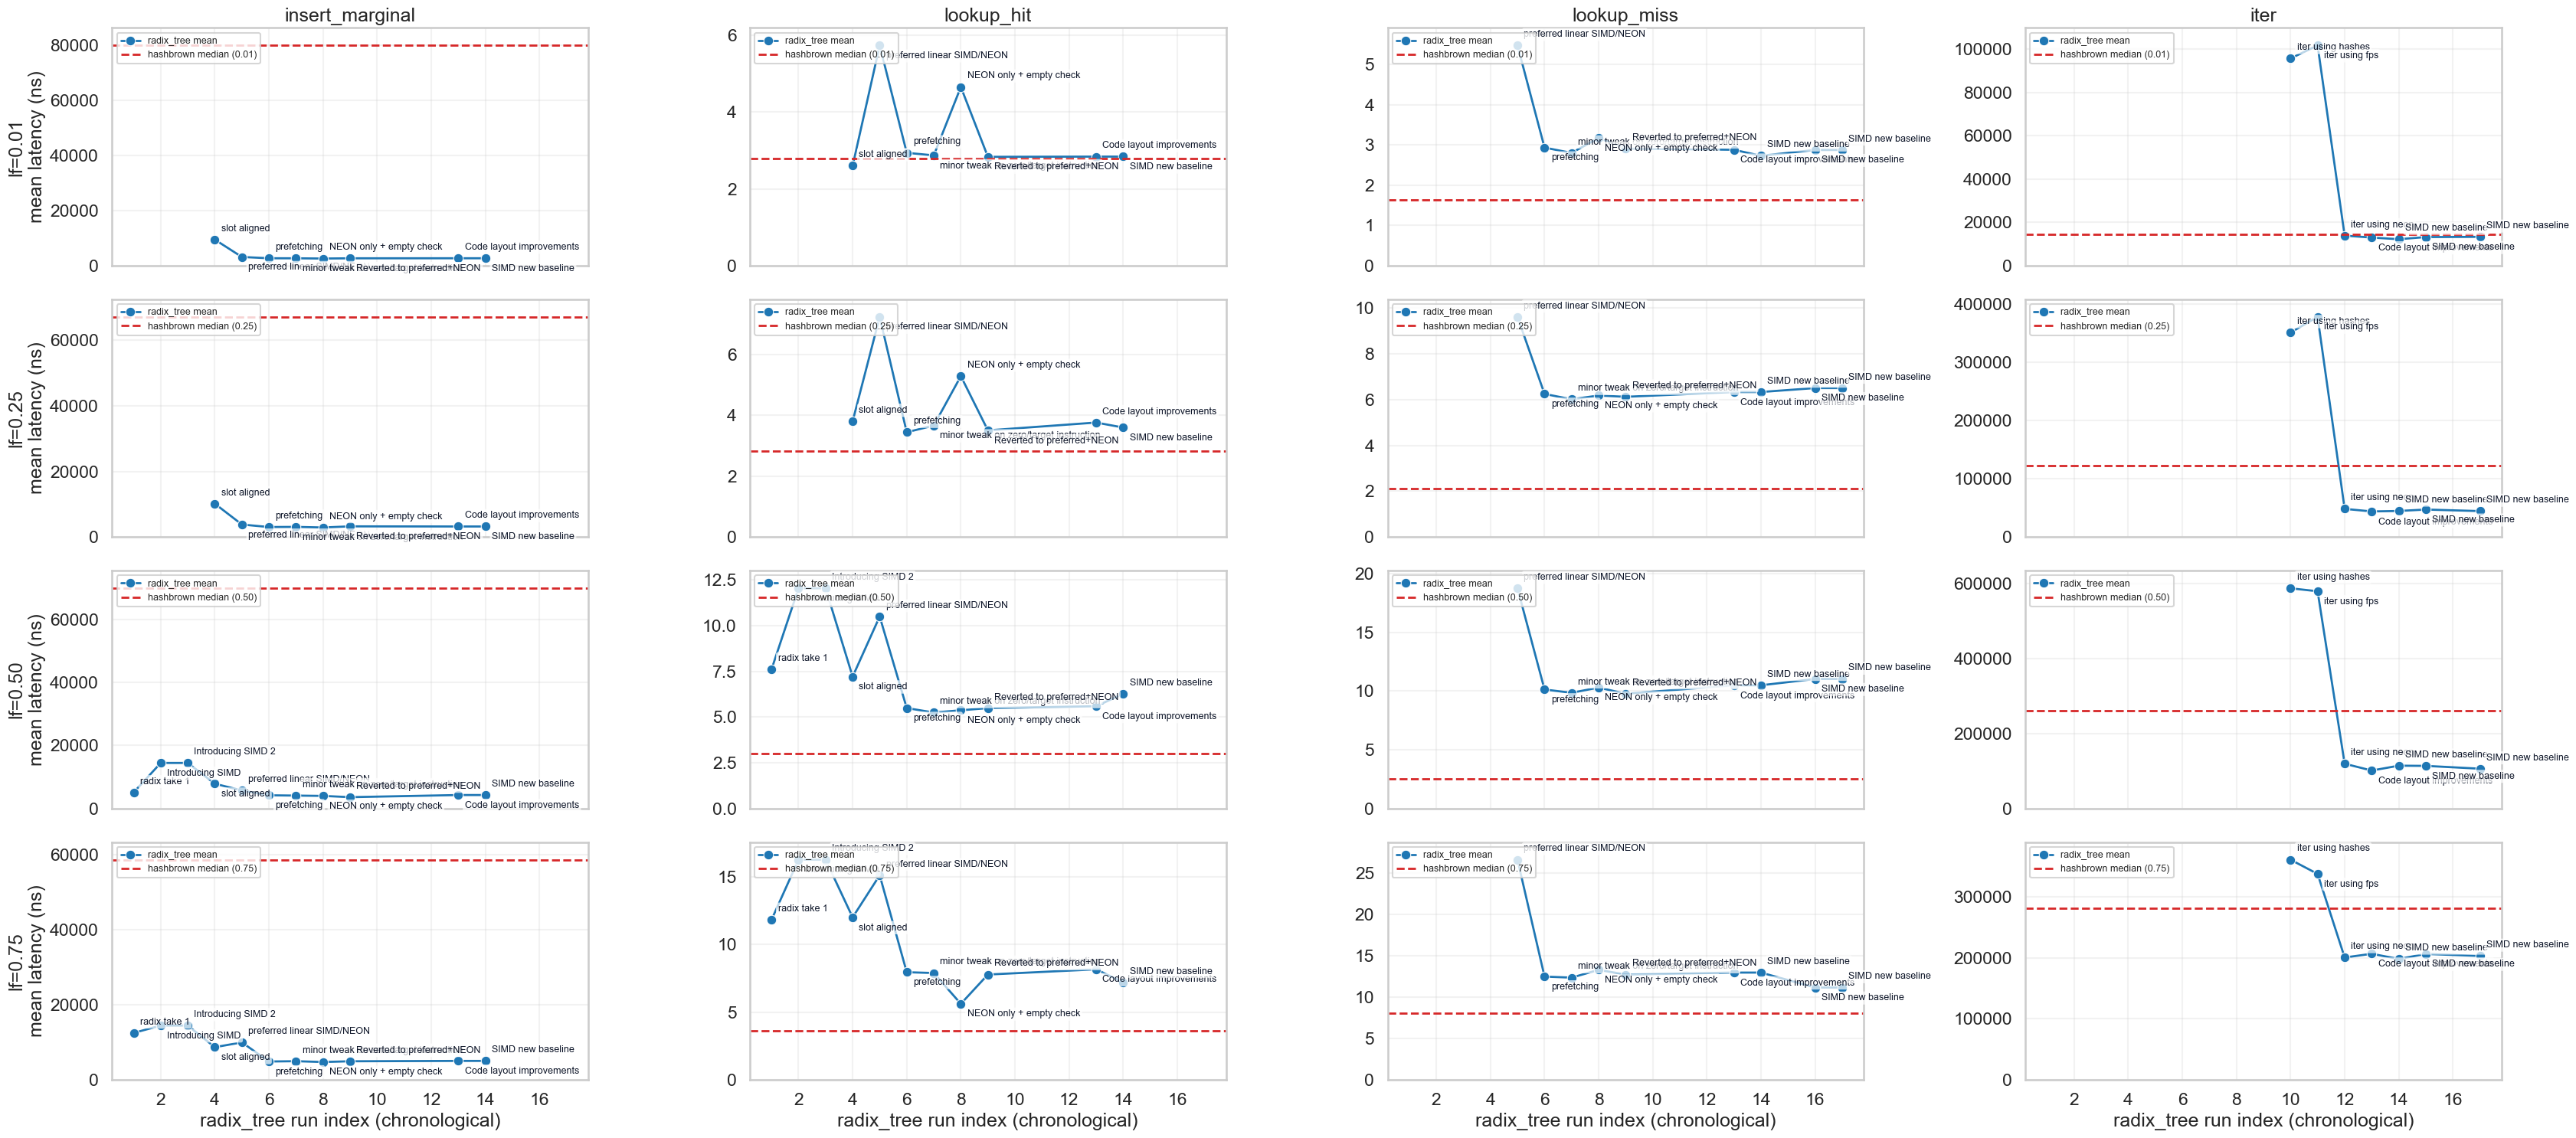

,impl,timestamp,tag,run_idx
136,radix_tree,2026-02-22 10:40:15.127746+00:00,radix take 1,1
152,radix_tree,2026-02-22 11:10:49.575216+00:00,Introducing SIMD,2
168,radix_tree,2026-02-22 11:17:38.113651+00:00,Introducing SIMD 2,3
184,radix_tree,2026-02-25 08:25:35.261066+00:00,slot aligned,4
216,radix_tree,2026-02-25 09:57:11.537607+00:00,preferred linear SIMD/NEON,5
264,radix_tree,2026-02-25 11:15:32.495232+00:00,prefetching,6
312,radix_tree,2026-02-25 11:19:33.740525+00:00,minor tweak on zero/target instruction,7
360,radix_tree,2026-02-25 22:44:41.591567+00:00,NEON only + empty check,8
408,radix_tree,2026-02-25 22:52:48.109435+00:00,Reverted to preferred+NEON,9
456,radix_tree,2026-02-26 07:16:39.746455+00:00,iter using hashes,10


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Track optimization progress for radix_tree using mean latency only.
required_cols = ["timestamp", "impl", "op", "load_factor", "metric", "unit", "value", "tag"]
missing_cols = [c for c in required_cols if c not in df_cmp.columns]
if missing_cols:
    raise ValueError(f"Missing columns needed for progress charts: {missing_cols}")

plot_src = df_cmp.copy()
plot_src["timestamp"] = pd.to_datetime(plot_src["timestamp"], utc=True, errors="coerce")
plot_src["load_factor"] = pd.to_numeric(plot_src["load_factor"], errors="coerce")

# Focus only on mean latency (ns); ignore median/std_dev/throughput for now.
mean_ns = plot_src[(plot_src["metric"] == "mean") & (plot_src["unit"] == "ns")].copy()

# A benchmark run is identified by implementation + timestamp + tag.
run_meta = (
    mean_ns[["impl", "timestamp", "tag"]]
    .drop_duplicates()
    .sort_values(["impl", "timestamp", "tag"])
)
run_meta["run_idx"] = run_meta.groupby("impl").cumcount() + 1

mean_ns = mean_ns.merge(run_meta, on=["impl", "timestamp", "tag"], how="left")

radix = mean_ns[mean_ns["impl"] == "radix_tree"].copy()
hashbrown = mean_ns[mean_ns["impl"] == "m0_hashbrown"].copy()

if radix.empty:
    raise ValueError("No radix_tree mean/ns data found.")
if hashbrown.empty:
    raise ValueError("No m0_hashbrown mean/ns data found for reference lines.")

# Hashbrown reference = median value across its runs for each (op, load_factor).
hb_ref = (
    hashbrown.groupby(["op", "load_factor"], as_index=False)["value"]
    .median()
    .rename(columns={"value": "hb_median_ns"})
)

ops_order = ["insert_marginal", "lookup_hit", "lookup_miss", "iter"]
ops_present = [op for op in ops_order if op in radix["op"].unique()]
if not ops_present:
    raise ValueError("No target ops found for radix_tree.")

# User-facing layout target: rows = load factors, cols = operations.
# Use only load factors that exist for ALL selected ops to avoid empty panels.
load_sets = [
    set(radix[radix["op"] == op]["load_factor"].dropna().unique())
    for op in ops_present
]
common_loads = sorted(set.intersection(*load_sets)) if load_sets else []

# Order rows by occupancy (low -> high).
preferred_loads = [0.01, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
loads_present = [lf for lf in preferred_loads if lf in common_loads]

if len(loads_present) < 4:
    backfill = [lf for lf in common_loads if lf not in loads_present]
    loads_present = (loads_present + backfill)[:4]
else:
    loads_present = loads_present[:4]

if len(loads_present) < 4:
    print(f"Only {len(loads_present)} common load factors found across selected ops: {loads_present}")
else:
    print(f"Using load factors for matrix layout: {loads_present}")

n_rows = len(loads_present)
n_cols = len(ops_present)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(8.5 * n_cols, 3.8 * n_rows),
    sharex=True,
    squeeze=False,
)

for r, lf in enumerate(loads_present):
    for c, op in enumerate(ops_present):
        ax = axes[r][c]
        y_max = 0.0

        series = radix[(radix["op"] == op) & (radix["load_factor"] == lf)].sort_values("run_idx")
        if not series.empty:
            sns.lineplot(
                data=series,
                x="run_idx",
                y="value",
                marker="o",
                linewidth=2,
                color="#1f77b4",
                ax=ax,
                label="radix_tree mean",
            )
            y_max = max(y_max, float(series["value"].max()))

            # Label every datapoint with its run tag for optimization traceability.
            for i, (_, point) in enumerate(series.iterrows()):
                y_offset = 8 if i % 2 == 0 else -12
                ax.annotate(
                    str(point["tag"]),
                    xy=(point["run_idx"], point["value"]),
                    xytext=(6, y_offset),
                    textcoords="offset points",
                    fontsize=9,
                    color="#0f172a",
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
                )

        # Baseline matched exactly to this subplot's op + load_factor.
        base = hb_ref[(hb_ref["op"] == op) & (hb_ref["load_factor"] == lf)]
        if not base.empty:
            y_base = float(base.iloc[0]["hb_median_ns"])
            y_max = max(y_max, y_base)
            ax.axhline(
                y=y_base,
                linestyle="--",
                linewidth=2,
                color="#d62728",
                label=f"hashbrown median ({lf:.2f})",
            )

        if r == 0:
            ax.set_title(op)
        if c == 0:
            ax.set_ylabel(f"lf={lf:.2f}\nmean latency (ns)")
        else:
            ax.set_ylabel("")

        if y_max > 0:
            # Add headroom so a baseline at the max value is visible (not clipped to top border).
            ax.set_ylim(0, y_max * 1.08)

        ax.grid(True, alpha=0.25)
        ax.legend(loc="upper left", fontsize=9, frameon=True)

for c in range(n_cols):
    axes[-1][c].set_xlabel("radix_tree run index (chronological)")

plt.tight_layout()
plt.show()

# Optional helper table: run index mapping for traceability.
display(run_meta[run_meta["impl"] == "radix_tree"].sort_values("run_idx"))